# Transfer learning : DenseNet 

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201

## ResNet과 DenseNet의 차이
이전 layer들의 feature map을 계속해서 다음 layer의 입력과 연결하는 방식이며 <br>
이러한 방식은 ResNet에서도 사용이 되었습니다.<br> 
다만 ResNet은 feature map 끼리 더하기 를 해주는 방식이었다면<br> 
DenseNet은 feature map끼리 Concatenation 을 시키는 것이 가장 큰 차이점<br>

![](https://oi.readthedocs.io/en/latest/_images/cnn_vs_resnet_vs_densenet.png)

## 장점

Vanishing Gradient 개선<br>
Feature Propagation 강화<br>
Feature Reuse<br>
Parameter 수 절약<br>

![](https://wikidocs.net/images/page/121707/Screenshot_2021-03-22_1608_06993_pdf2.png)

# transfer learning 연습

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# 성능을 높이도록 데이터세트 구성하기
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 데이터 증강
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
## 특징추출

In [ ]:
# 컨볼루션 베이스모델 고정

base_model.trainable = False

# train, test 나누기

In [ ]:
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
import shutil

In [ ]:
train_path = Path('./data/tf_practice/train') # train test로 구분한 파일 저장 경로
test_path = Path('./data/tf_practice/test')

train_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

In [ ]:
data_path = Path('C:/KDT4/fintech/프로젝트3/data/padding/') # 원본 파일들 저장 경로
data = []
for d in data_path.glob('*'):
    for f in d.glob('*.jpg'):  # 현재 디렉터리의 .jpg 파일
        data.append([f, d.stem])
data = np.array(data)
data

In [ ]:
ss = StratifiedShuffleSplit(1, train_size = 0.8) # stratify: 비율 유지하면서 쪼개주는 역할
train_ix, test_ix = next(ss.split(data[:,0],data[:,1]))
train_ix

In [ ]:
train_set, test_set = data[train_ix], data[test_ix]
train_set

In [ ]:
for p, c in train_set:
    (train_path / c).mkdir(exist_ok=True)
    shutil.move(p, train_path.joinpath(*p.parts[-2:]))
for p, c in test_set:
    (test_path / c).mkdir(exist_ok=True)
    shutil.move(p, test_path.joinpath(*p.parts[-2:]))

# steps_per_epochs, validation_steps 설정
n * e = b * s

num of sample : 전체 학습할 데이터(training examples)의 개수<br>
n = 1회 운동 당 벤치 프레스 목표 개수 (40개)

e = epochs: 몇 번 반복할 것인가? 1회<br>
<br>

b = batch size: 1세트 당 회수. 8개

s = steps: 몇 세트로 나누어 할 것인가. 5 세트

* steps_per_epoch= train_generator.samples//train_generator.batch_size

# transfer learning 사용하기

In [54]:
# GPU 작동확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13430212485210482720
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6259015680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3934386996900743162
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [55]:
# import os
# import tensorflow as tf
# os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [56]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [57]:
# (224,224,3)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [59]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory


## densenet121

In [41]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)

In [42]:
train_generator = train_datagen.flow_from_directory('./data/tf_practice/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')

Found 524 images belonging to 20 classes.


In [ ]:
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
val_generator = val_datagen.flow_from_directory('./data/tf_practice/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')

In [43]:
# test
test_datagen = ImageDataGenerator(rescale = 1./255)

In [44]:
test_generator = test_datagen.flow_from_directory('./data/tf_practice/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 131 images belonging to 20 classes.


In [45]:
from tensorflow.keras.applications import densenet
with tf.device('/GPU:0'):
    Dense_model = densenet.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_shape=(224,224,3)
                                         )

Dense_model.trainable = True

In [46]:
Dense_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                       

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 7, 7, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

In [47]:
finetune_model = Sequential()
finetune_model.add(Dense_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(1400, activation='relu'))
finetune_model.add(Dense(700, activation='relu'))
finetune_model.add(Dense(564, activation='softmax'))
finetune_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                3211328   
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 20)                660       
                                                                 
Total params: 10,251,572
Trainable params: 3,214,068
Non-trainable params: 7,037,504
_________________________________________________________________


In [48]:
finetune_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [51]:
hist = finetune_model.fit(
    train_generator,
    epochs = 100,
    steps_per_epoch= train_generator.samples//train_generator.batch_size,
    validation_data= val_generator,
    validation_steps= val_generator.samples//test_generator.batch_size
)

Epoch 1/50
52/52 [==============================] - 9s 98ms/step - loss: 3.3597 - accuracy: 0.2432 - val_loss: 1.8116 - val_accuracy: 0.4231
Epoch 2/50
52/52 [==============================] - 4s 74ms/step - loss: 1.2538 - accuracy: 0.6381 - val_loss: 1.1507 - val_accuracy: 0.6692
Epoch 3/50
52/52 [==============================] - 4s 73ms/step - loss: 0.7973 - accuracy: 0.7665 - val_loss: 0.9626 - val_accuracy: 0.6846
Epoch 4/50
52/52 [==============================] - 4s 73ms/step - loss: 0.3787 - accuracy: 0.8911 - val_loss: 0.9766 - val_accuracy: 0.7077
Epoch 5/50
52/52 [==============================] - 4s 72ms/step - loss: 0.2036 - accuracy: 0.9494 - val_loss: 0.9112 - val_accuracy: 0.7000
Epoch 6/50
52/52 [==============================] - 4s 76ms/step - loss: 0.0975 - accuracy: 0.9728 - val_loss: 0.9650 - val_accuracy: 0.7462
Epoch 7/50
52/52 [==============================] - 4s 75ms/step - loss: 0.0564 - accuracy: 0.9922 - val_loss: 0.8285 - val_accuracy: 0.8077
Epoch 8/50
52

In [49]:
print(len(finetune_model.trainable_weights))

6


In [50]:
train_generator.samples

524

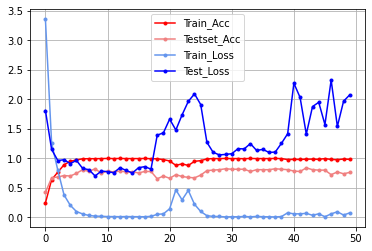

In [52]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

x_len = np.arange(len(loss))
plt.plot(x_len, acc, marker='.', c='red', label='Train_Acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Testset_Acc')
plt.plot(x_len, loss, marker='.', c='cornflowerblue', label='Train_Loss')
plt.plot(x_len, val_loss, marker='.', c='blue', label='Test_Loss')

plt.legend()
plt.grid()
plt.show()

In [ ]:
# 모델 평가
model.evaluate(test_generator)

## NesNet Mobile_1번째시도

In [82]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [83]:
#nasnetmobile

from tensorflow.keras.applications import nasnet
with tf.device('/GPU:0'):
    model = tf.keras.applications.nasnet.NASNetMobile(
                                                        input_shape=(224,224,3),
                                                        include_top=False,
                                                        weights='imagenet'
                                                        )
model.trainable = True

In [84]:
model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_383[0][0]']         
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_385 (Activation)    (None, 56, 56, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 56, 56, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add_8 (Add)                    (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d_8 (Cropping2D)      (None, 111, 111, 32  0           ['zero_padding2d_14[0][0]']      
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_392[0][0]']         
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_394 (Activation)    (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 28, 28, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 28, 28, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_15 (ZeroPadding  (None, 57, 57, 44)  0           ['adjust_relu_1_0[0][0]']        
 2D)                                                                                              
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_400 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_409 (Activation)    (None, 28, 28, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_410 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_416[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_418[0][0]']         
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 44)  2332        ['activation_420[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_431 (Activation)    (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_423[0][0]']         
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 44)  2332        ['activation_425[0][0]']         
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 28, 28, 44)  3036        ['activation_427[0][0]']         
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_436 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_438 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_440 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_446 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_445 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 28, 28, 88)  23232       ['activation_446[0][0]']         
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 28, 28, 88)  23232       ['activation_445[0][0]']         
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 14, 14, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 88)  8536        ['activation_455[0][0]']         
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_10 (Cropping2D)     (None, 28, 28, 264)  0           ['zero_padding2d_16[0][0]']      
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 14, 14, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_10[0][0]',                
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_465 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_467 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_459[0][0]']         
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_470 (Activation)    (None, 14, 14, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_472 (Activation)    (None, 14, 14, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 14, 14, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 14, 14, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 14, 14, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_495[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 88)  8536        ['activation_497[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 88)  9944        ['activation_499[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_506 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_508 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 17, 17, 176)  0          ['activation_506[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_508[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 15, 15, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_516 (Activation)    (None, 7, 7, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 7, 7, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_524[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_526[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_529[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_531[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 7, 7, 176)   35376       ['activation_533[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 7, 7, 176)   32560       ['activation_535[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_542 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_544 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_546 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_548 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

 activation_552 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 7, 7, 176)   185856      ['activation_551[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 7, 7, 176)    185856      ['activation_552[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 7, 7, 176)   704         ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (B

In [85]:
finetune_model1 = Sequential()
finetune_model1.add(model)
finetune_model1.add(Flatten())
finetune_model1.add(Dense(200,activation='relu'))
finetune_model1.add(Dense(100,activation='relu'))
finetune_model1.add(Dense(73,activation='softmax'))

In [86]:
finetune_model1.compile(loss ='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

In [87]:
hist1 = finetune_model1.fit(train_generator,
                           epochs=100,
                           steps_per_epoch = train_generator.samples//train_generator.batch_size,
                           validation_data= val_generator,
                            validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/100
906/906 [==============================] - 274s 284ms/step - loss: 3.9987 - accuracy: 0.0492 - val_loss: 203.5890 - val_accuracy: 0.0233
Epoch 2/100
906/906 [==============================] - 256s 283ms/step - loss: 2.8261 - accuracy: 0.2289 - val_loss: 68.8399 - val_accuracy: 0.0363
Epoch 3/100
906/906 [==============================] - 257s 283ms/step - loss: 1.5867 - accuracy: 0.5400 - val_loss: 46.6734 - val_accuracy: 0.0364
Epoch 4/100
906/906 [==============================] - 255s 281ms/step - loss: 0.8400 - accuracy: 0.7442 - val_loss: 105.2688 - val_accuracy: 0.0254
Epoch 5/100
906/906 [==============================] - 257s 283ms/step - loss: 0.5456 - accuracy: 0.8309 - val_loss: 37.3434 - val_accuracy: 0.0832
Epoch 6/100
906/906 [==============================] - 256s 282ms/step - loss: 0.3942 - accuracy: 0.8762 - val_loss: 44.0002 - val_accuracy: 0.0440
Epoch 7/100
906/906 [==============================] - 256s 282ms/step - loss: 0.3267 - accuracy: 0.8946 - val

### nasnet1 결과 시각화

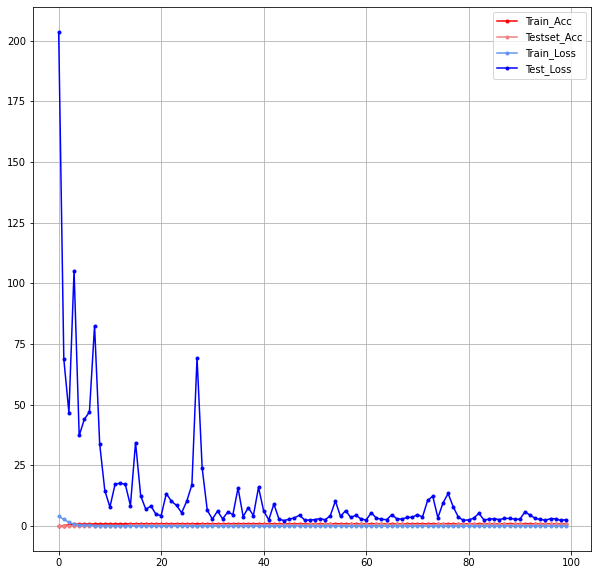

In [94]:
acc = hist1.history['accuracy']
val_acc = hist1.history['val_accuracy']

loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

x_len = np.arange(len(loss))
plt.figure(figsize=(10,10))
plt.plot(x_len, acc, marker='.', c='red', label='Train_Acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Testset_Acc')

plt.plot(x_len, loss, marker='.', c='cornflowerblue', label='Train_Loss')
plt.plot(x_len, val_loss, marker='.', c='blue', label='Test_Loss')

plt.legend()
plt.grid()
plt.show()

In [96]:
finetune_model1.evaluate(test_generator)

348/348 [==============================] - 61s 176ms/step - loss: 2.7233 - accuracy: 0.6947


[2.723261594772339, 0.6946839094161987]

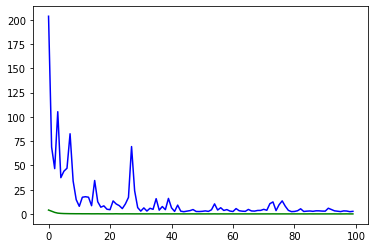

In [137]:
plt.plot(hist1.history['loss'],color='green')
plt.plot(hist1.history['val_loss'],color='blue')

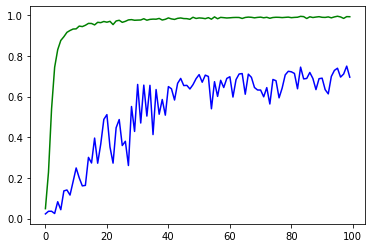

In [138]:
plt.plot(hist1.history['accuracy'],color='green')
plt.plot(hist1.history['val_accuracy'],color='blue')

In [164]:
scores = finetune_model1.evaluate_generator(test_generator)
scores

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/152142024.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = finetune_model1.evaluate_generator(test_generator,steps=5)


[2.042531967163086, 0.7400000095367432]

In [169]:
# test 예측
test_pred = finetune_model1.predict_generator(test_generator,steps=5) # 클래스 별 확률벡터
test_pred
np.argmax(test_pred[0]) # 가장 큰값의 인덱스 -> 첫번째 사진은 65번째로 예측

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/1352882801.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_pred = finetune_model1.predict_generator(test_generator,steps=5) # 클래스 별 확률벡터


65

In [168]:
test_pred[0]

array([2.44745105e-14, 7.31741853e-15, 1.68547308e-06, 9.97024057e-19,
       1.42701277e-23, 1.03362166e-10, 1.54071316e-08, 4.10384816e-18,
       2.98269791e-13, 5.10689058e-19, 1.27318955e-09, 7.16339084e-14,
       8.40961584e-15, 7.51080602e-22, 3.02154588e-26, 4.98968922e-13,
       7.29574696e-19, 2.71593692e-25, 7.25589988e-09, 1.36315395e-12,
       1.30701988e-16, 1.17302095e-19, 1.17346752e-13, 2.43364023e-10,
       2.74416432e-14, 5.05360349e-24, 9.99996543e-01, 2.62185984e-09,
       7.97986417e-12, 9.60870923e-13, 1.16218985e-06, 9.61954672e-17,
       6.95580260e-10, 4.00469642e-13, 1.66806358e-12, 1.53866161e-14,
       5.74698206e-11, 2.31248587e-13, 4.15800554e-12, 5.10532161e-23,
       1.31642544e-11, 9.63059146e-11, 3.43767031e-17, 2.82780007e-07,
       5.29253065e-11, 4.82113371e-09, 1.38868832e-12, 2.28696666e-20,
       4.14974224e-08, 1.52295190e-08, 5.12589011e-08, 2.73508799e-10,
       3.73385955e-26, 2.06230008e-19, 7.76766414e-14, 2.62197428e-17,
      

In [170]:
# 예측결과
print("-- Predict --")
output = finetune_model1.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Predict --


C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/1736889974.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  output = finetune_model1.predict_generator(test_generator, steps=5)


{'class_005': 0, 'class_009': 1, 'class_029': 2, 'class_038': 3, 'class_040': 4, 'class_047': 5, 'class_049': 6, 'class_051': 7, 'class_055': 8, 'class_060': 9, 'class_064': 10, 'class_065': 11, 'class_066': 12, 'class_067': 13, 'class_068': 14, 'class_074': 15, 'class_078': 16, 'class_080': 17, 'class_092': 18, 'class_095': 19, 'class_097': 20, 'class_098': 21, 'class_100': 22, 'class_103': 23, 'class_106': 24, 'class_107': 25, 'class_110': 26, 'class_112': 27, 'class_114': 28, 'class_115': 29, 'class_116': 30, 'class_124': 31, 'class_127': 32, 'class_128': 33, 'class_129': 34, 'class_133': 35, 'class_134': 36, 'class_140': 37, 'class_146': 38, 'class_151': 39, 'class_153': 40, 'class_154': 41, 'class_174': 42, 'class_178': 43, 'class_179': 44, 'class_180': 45, 'class_184': 46, 'class_230': 47, 'class_240': 48, 'class_242': 49, 'class_244': 50, 'class_247': 51, 'class_257': 52, 'class_268': 53, 'class_279': 54, 'class_285': 55, 'class_288': 56, 'class_289': 57, 'class_324': 58, 'class

In [196]:
# 모델저장

finetune_model1.save('./data/model_result/nasnet1.h5',save_format='h5')


## NesnetMobile_2번째시도: 성능 안좋음

In [201]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [202]:
#nasnetmobile

from tensorflow.keras.applications import nasnet
with tf.device('/GPU:0'):
    nas_model2 = tf.keras.applications.nasnet.NASNetMobile(
                                                        input_shape=(224,224,3),
                                                        include_top=False,
                                                        weights='imagenet'
                                                        )
nas_model2.trainable = True

In [203]:
nasnet_model2 = Sequential()
nasnet_model2.add(nas_model2)
nasnet_model2.add(Flatten())
nasnet_model2.add(Dense(512,activation='relu'))
nasnet_model2.add(Dense(256,activation='relu'))
nasnet_model2.add(Dense(128,activation='relu'))

nasnet_model2.add(Dense(73,activation='softmax'))

In [204]:
nasnet_model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [205]:
hist_nas2 = nasnet_model2.fit(train_generator,epochs=100, 
                              steps_per_epoch=train_generator.samples//train_generator.batch_size,
                              validation_data = val_generator,
                             validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/100
906/906 [==============================] - 323s 339ms/step - loss: 4.1944 - accuracy: 0.0401 - val_loss: 21.8536 - val_accuracy: 0.0375
Epoch 2/100
906/906 [==============================] - 303s 334ms/step - loss: 3.5676 - accuracy: 0.0983 - val_loss: 81.7502 - val_accuracy: 0.0131
Epoch 3/100
906/906 [==============================] - 303s 335ms/step - loss: 2.7760 - accuracy: 0.2184 - val_loss: 130.2220 - val_accuracy: 0.0397
Epoch 4/100
906/906 [==============================] - 302s 333ms/step - loss: 1.8588 - accuracy: 0.4406 - val_loss: 87.5310 - val_accuracy: 0.0259
Epoch 5/100
906/906 [==============================] - 304s 335ms/step - loss: 1.2424 - accuracy: 0.6183 - val_loss: 37.7677 - val_accuracy: 0.0379
Epoch 6/100
906/906 [==============================] - 303s 334ms/step - loss: 0.8271 - accuracy: 0.7445 - val_loss: 25.6193 - val_accuracy: 0.0459
Epoch 7/100
906/906 [==============================] - 304s 336ms/step - loss: 0.5821 - accuracy: 0.8200 - val_

KeyboardInterrupt: 

In [ ]:
nasnet_model2.save('./data/model_result/nasnet2.h5')

## EfficientNetB0 

In [120]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [250]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [251]:
from tensorflow.keras.applications import efficientnet
with tf.device('/GPU:0'):
    efficient_model = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet',
                                                             include_top= False,
                                                              input_shape=(224,224,3),
                                                              classifier_activation="softmax"
                                                                )
efficient_model.trainable = True

In [252]:
efficient_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_28[0][0]']               
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                     

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

In [253]:
finetune_model2 = Sequential()
finetune_model2.add(efficient_model)

finetune_model2.add(Flatten())

finetune_model2.add(Dense(200,activation='relu'))
finetune_model2.add(Dense(150,activation='relu'))
finetune_model2.add(Dense(100,activation='relu'))

finetune_model2.add(Dense(73,activation='softmax'))


In [254]:
finetune_model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [255]:
hist2 = finetune_model2.fit(train_generator,epochs=20,
                            steps_per_epoch=train_generator.samples//train_generator.batch_size,
                           validation_data=val_generator, validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/20
906/906 [==============================] - 337s 365ms/step - loss: 2.7528 - accuracy: 0.3270 - val_loss: 20.4472 - val_accuracy: 0.0109
Epoch 2/20
906/906 [==============================] - 250s 276ms/step - loss: 0.9453 - accuracy: 0.7374 - val_loss: 4717.1099 - val_accuracy: 0.0276
Epoch 3/20
906/906 [==============================] - 250s 276ms/step - loss: 0.5588 - accuracy: 0.8382 - val_loss: 4.5557 - val_accuracy: 0.0319
Epoch 4/20
906/906 [==============================] - 255s 281ms/step - loss: 0.4769 - accuracy: 0.8636 - val_loss: 3385.8259 - val_accuracy: 0.0133
Epoch 5/20
906/906 [==============================] - 252s 278ms/step - loss: 0.3708 - accuracy: 0.8927 - val_loss: 9694.9551 - val_accuracy: 0.0102
Epoch 6/20
906/906 [==============================] - 250s 275ms/step - loss: 0.3387 - accuracy: 0.9033 - val_loss: 7.5631 - val_accuracy: 0.0190
Epoch 7/20
906/906 [==============================] - 248s 273ms/step - loss: 0.3154 - accuracy: 0.9127 - val_loss

In [131]:
# # callback 생성하기
# import os
# import keras
# cur_dir = os.getcwd()
# ckpt_dir = 'checkpoints' # weight를 저장할 디렉토리
# file_name = 'eff_smallclass_weights.ckpt'

# ckpt_path = os.path.join(cur_dir, 'callback_efficientnet')
# os.makedirs(ckpt_path, exist_ok=True)

# ckpt_filepath = os.path.join(ckpt_path, 'eff_smallclass_{epoch}' )

# ckpt_callback = keras.callbacks.ModelCheckpoint(filepath = ckpt_filepath, 
#                                                save_weights_only=False) # True weight만 , False 모델까지
# # early stopping callback
# early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

# # callbacks=[]

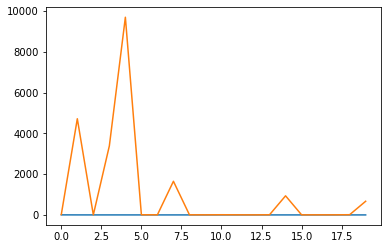

In [256]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

In [257]:
finetune_model2.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/3730870188.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  finetune_model2.evaluate_generator(test_generator)


[657.1809692382812, 0.011206896975636482]

In [272]:
finetune_model2.save('./data/model_result/efficentnet.h5')

## MobileNet_3 : dropout  

In [206]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [207]:
from tensorflow.keras.applications import mobilenet
with tf.device('/GPU:0'):
    mob_model3 = tf.keras.applications.mobilenet.MobileNet(weights='imagenet',
                                                             include_top= False,
                                                              input_shape=(224,224,3),
                                                              classifier_activation="softmax"
                                                                )
mob_model3.trainable = True

In [208]:
Mb_model3 = Sequential()
Mb_model3.add(mob_model3)

Mb_model3.add(Flatten())

Mb_model3.add(Dense(1024,activation='relu'))
Mb_model3.add(Dense(512,activation='relu'))
Mb_model3.add(Dropout(0.1))
Mb_model3.add(Dense(256,activation='relu'))
Mb_model3.add(Dense(128,activation='relu'))
Mb_model3.add(Dropout(0.1))
Mb_model3.add(Dense(100,activation='relu'))

Mb_model3.add(Dense(73,activation='softmax'))

In [209]:
Mb_model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [210]:
Mb_hist3 = Mb_model3.fit(train_generator,epochs=100,
                            steps_per_epoch=train_generator.samples//train_generator.batch_size,
                           validation_data=val_generator, validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/100
906/906 [==============================] - 325s 357ms/step - loss: 4.0550 - accuracy: 0.0496 - val_loss: 3.7276 - val_accuracy: 0.0988
Epoch 2/100
906/906 [==============================] - 245s 270ms/step - loss: 3.3710 - accuracy: 0.1156 - val_loss: 3.0667 - val_accuracy: 0.1602
Epoch 3/100
906/906 [==============================] - 251s 277ms/step - loss: 2.8335 - accuracy: 0.2016 - val_loss: 3.0020 - val_accuracy: 0.2210
Epoch 4/100
906/906 [==============================] - 259s 286ms/step - loss: 2.3387 - accuracy: 0.3072 - val_loss: 2.4841 - val_accuracy: 0.3178
Epoch 5/100
906/906 [==============================] - 257s 284ms/step - loss: 1.8733 - accuracy: 0.4402 - val_loss: 2.2108 - val_accuracy: 0.4039
Epoch 6/100
906/906 [==============================] - 260s 287ms/step - loss: 1.4922 - accuracy: 0.5440 - val_loss: 2.0982 - val_accuracy: 0.4663
Epoch 7/100
906/906 [==============================] - 255s 281ms/step - loss: 1.1929 - accuracy: 0.6459 - val_loss: 1

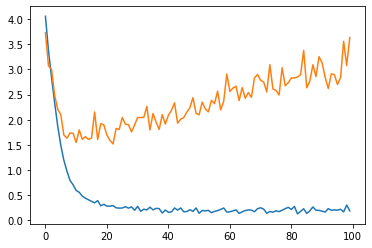

In [214]:
plt.plot(Mb_hist3.history['loss'])
plt.plot(Mb_hist3.history['val_loss'])

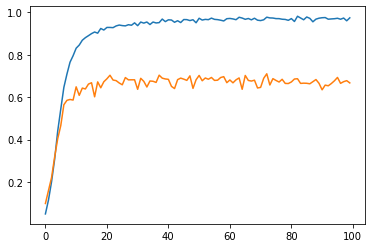

In [215]:
plt.plot(Mb_hist3.history['accuracy'])
plt.plot(Mb_hist3.history['val_accuracy'])

In [216]:
 Mb_model3.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/1159241667.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Mb_model3.evaluate_generator(test_generator)


[3.635704755783081, 0.6505746841430664]

In [217]:
 Mb_model3.save('./data/model_result/Mb_3_dropout.h5')

## Mobilenet_4 : optimizer adam learning rate 낮추기

In [187]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [188]:

from tensorflow.keras.applications import mobilenet
with tf.device('/GPU:0'):
    mob_model4 = tf.keras.applications.mobilenet.MobileNet(
                                                        input_shape=(224,224,3),
                                                        include_top=False,
                                                        weights='imagenet'
                                                        )
mob_model4.trainable = True

In [189]:
Mb_model4 = Sequential()
Mb_model4.add(mob_model4)

Mb_model4.add(Flatten())

Mb_model4.add(Dense(200,activation='relu'))
Mb_model4.add(Dense(100,activation='relu'))
Mb_model4.add(Dense(73,activation='softmax'))

In [191]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [192]:
Mb_model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = Adam)

In [193]:
Mb_hist4 = Mb_model4.fit(train_generator,
                           epochs=100,
                           steps_per_epoch = train_generator.samples//train_generator.batch_size,
                           validation_data= val_generator,
                            validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/100
906/906 [==============================] - 284s 311ms/step - loss: 2.3923 - accuracy: 0.4188 - val_loss: 1.4571 - val_accuracy: 0.6405
Epoch 2/100
906/906 [==============================] - 327s 361ms/step - loss: 0.6069 - accuracy: 0.8271 - val_loss: 0.8840 - val_accuracy: 0.7644
Epoch 3/100
906/906 [==============================] - 310s 342ms/step - loss: 0.3410 - accuracy: 0.8964 - val_loss: 1.1205 - val_accuracy: 0.7542
Epoch 4/100
906/906 [==============================] - 273s 301ms/step - loss: 0.2520 - accuracy: 0.9229 - val_loss: 0.8290 - val_accuracy: 0.8035
Epoch 5/100
906/906 [==============================] - 274s 303ms/step - loss: 0.2179 - accuracy: 0.9328 - val_loss: 0.8094 - val_accuracy: 0.8067
Epoch 6/100
906/906 [==============================] - 279s 308ms/step - loss: 0.1829 - accuracy: 0.9425 - val_loss: 0.7748 - val_accuracy: 0.8150
Epoch 7/100
906/906 [==============================] - 280s 309ms/step - loss: 0.1762 - accuracy: 0.9458 - val_loss: 0

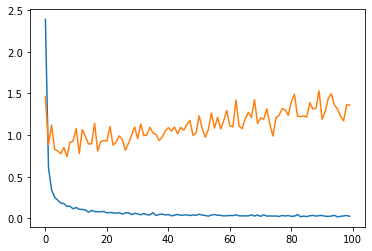

In [197]:
plt.plot(Mb_hist4.history['loss'])
plt.plot(Mb_hist4.history['val_loss'])

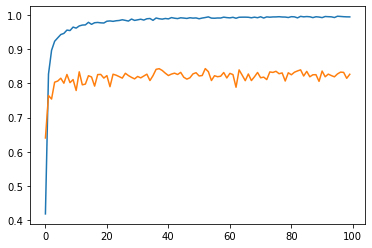

In [198]:
plt.plot(Mb_hist4.history['accuracy'])
plt.plot(Mb_hist4.history['val_accuracy'])

In [227]:
 Mb_model4.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/3423727293.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Mb_model4.evaluate_generator(test_generator)


[1.6098618507385254, 0.824999988079071]

In [200]:
 Mb_model4.save('./data/model_result/Mb_lr.h5')

## MobileNet_5: layer 숫자줄이기

In [218]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [219]:
from tensorflow.keras.applications import mobilenet
with tf.device('/GPU:0'):
    mob_model5 = tf.keras.applications.mobilenet.MobileNet(
                                                        input_shape=(224,224,3),
                                                        include_top=False,
                                                        weights='imagenet'
                                                        )
mob_model5.trainable = True

In [220]:
Mb_model5 = Sequential()
Mb_model5.add(mob_model5)

Mb_model5.add(Flatten())

Mb_model5.add(Dense(120,activation='relu'))
Mb_model5.add(Dense(90,activation='relu'))
Mb_model5.add(Dense(73,activation='softmax'))

In [221]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [222]:
Mb_model5.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = Adam)

In [223]:
Mb_hist5 = Mb_model5.fit(train_generator,
                           epochs=50,
                           steps_per_epoch = train_generator.samples//train_generator.batch_size,
                           validation_data= val_generator,
                            validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/50
906/906 [==============================] - 244s 267ms/step - loss: 3.7442 - accuracy: 0.1024 - val_loss: 3.5813 - val_accuracy: 0.1525
Epoch 2/50
906/906 [==============================] - 243s 268ms/step - loss: 2.1676 - accuracy: 0.3809 - val_loss: 2.1528 - val_accuracy: 0.4550
Epoch 3/50
906/906 [==============================] - 244s 269ms/step - loss: 1.1034 - accuracy: 0.6721 - val_loss: 1.3677 - val_accuracy: 0.6443
Epoch 4/50
906/906 [==============================] - 242s 267ms/step - loss: 0.6161 - accuracy: 0.8153 - val_loss: 1.0991 - val_accuracy: 0.7055
Epoch 5/50
906/906 [==============================] - 240s 265ms/step - loss: 0.4426 - accuracy: 0.8675 - val_loss: 1.1296 - val_accuracy: 0.7305
Epoch 6/50
906/906 [==============================] - 243s 269ms/step - loss: 0.3116 - accuracy: 0.9027 - val_loss: 1.1691 - val_accuracy: 0.7316
Epoch 7/50
906/906 [==============================] - 244s 269ms/step - loss: 0.2727 - accuracy: 0.9150 - val_loss: 0.9584 -

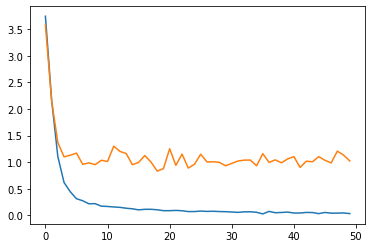

In [224]:
plt.plot(Mb_hist5.history['loss'])
plt.plot(Mb_hist5.history['val_loss'])

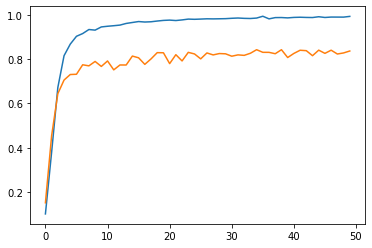

In [225]:
plt.plot(Mb_hist5.history['accuracy'])
plt.plot(Mb_hist5.history['val_accuracy'])

In [226]:
Mb_model5.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/1117553419.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Mb_model5.evaluate_generator(test_generator)


[1.1652888059616089, 0.8281609416007996]

In [247]:
Mb_model5.save('./data/model_result/Mb5.h5')

## MobileNet_6 : layer 작게 + layer 추가해보기

In [240]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [241]:
from tensorflow.keras.applications import mobilenet
with tf.device('/GPU:0'):
    mob_model6 = tf.keras.applications.mobilenet.MobileNet(
                                                        input_shape=(224,224,3),
                                                        include_top=False,
                                                        weights='imagenet'
                                                        )
mob_model6.trainable = True

In [242]:
Mb_model6 = Sequential()
Mb_model6.add(mob_model6)

Mb_model6.add(Flatten())

Mb_model6.add(Dense(120,activation='relu'))
Mb_model6.add(Dense(100,activation='relu'))
Mb_model6.add(Dense(80,activation='relu'))
Mb_model6.add(Dense(73,activation='softmax'))

In [243]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [244]:
Mb_model6.compile(loss= 'categorical_crossentropy', metrics=['accuracy'], optimizer= Adam)

In [245]:
Mb_hist6 = Mb_model6.fit(train_generator,
                           epochs=50,
                           steps_per_epoch = train_generator.samples//train_generator.batch_size,
                           validation_data= val_generator,
                            validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/50
906/906 [==============================] - 239s 262ms/step - loss: 2.3343 - accuracy: 0.4230 - val_loss: 1.6873 - val_accuracy: 0.5829
Epoch 2/50
906/906 [==============================] - 238s 262ms/step - loss: 0.7038 - accuracy: 0.7973 - val_loss: 1.1744 - val_accuracy: 0.7076
Epoch 3/50
906/906 [==============================] - 237s 262ms/step - loss: 0.4136 - accuracy: 0.8772 - val_loss: 0.9912 - val_accuracy: 0.7418
Epoch 4/50
906/906 [==============================] - 238s 263ms/step - loss: 0.3109 - accuracy: 0.9048 - val_loss: 0.9831 - val_accuracy: 0.7510
Epoch 5/50
906/906 [==============================] - 239s 264ms/step - loss: 0.2467 - accuracy: 0.9233 - val_loss: 1.0348 - val_accuracy: 0.7516
Epoch 6/50
906/906 [==============================] - 239s 264ms/step - loss: 0.2252 - accuracy: 0.9306 - val_loss: 0.9553 - val_accuracy: 0.7695
Epoch 7/50
906/906 [==============================] - 238s 263ms/step - loss: 0.1788 - accuracy: 0.9448 - val_loss: 0.8074 -

In [248]:
Mb_model6.save('./data/model_result/Mb6.h5')

In [249]:
Mb_model6.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/129227879.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Mb_model6.evaluate_generator(test_generator)


[0.9460495114326477, 0.8373563289642334]

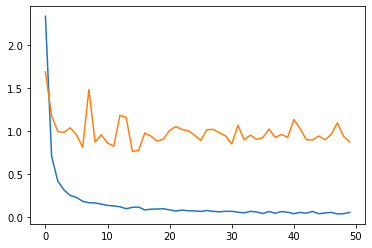

In [258]:
plt.plot(Mb_hist6.history['loss'])
plt.plot(Mb_hist6.history['val_loss'])

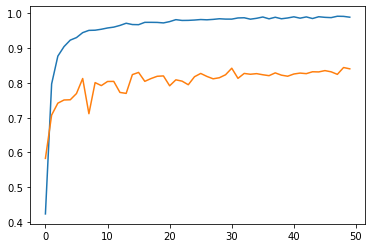

In [260]:
plt.plot(Mb_hist6.history['accuracy'])
plt.plot(Mb_hist6.history['val_accuracy'])

## MobileNet_7 : layer 작게 + learning rate 더 낮춰보기

In [261]:
# train 
train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory('./data/smallclass/train',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# validation
val_datagen = ImageDataGenerator(rescale=1./255.)
val_generator = val_datagen.flow_from_directory('./data/smallclass/val',
                                      target_size = (224,224),
                                      batch_size=20,
                                      class_mode='categorical')
# test
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('./data/smallclass/test',
                                       target_size = (224,224),
                                       batch_size =20, 
                                       class_mode = 'categorical')

Found 18134 images belonging to 73 classes.
Found 6870 images belonging to 73 classes.
Found 6960 images belonging to 73 classes.


In [262]:
from tensorflow.keras.applications import mobilenet
with tf.device('/GPU:0'):
    mob_model7 = tf.keras.applications.mobilenet.MobileNet(
                                                        input_shape=(224,224,3),
                                                        include_top=False,
                                                        weights='imagenet'
                                                        )
mob_model7.trainable = True

In [263]:
Mb_model7 = Sequential()
Mb_model7.add(mob_model7)

Mb_model7.add(Flatten())

Mb_model7.add(Dense(120,activation='relu'))
Mb_model7.add(Dense(100,activation='relu'))
Mb_model7.add(Dense(80,activation='relu'))
Mb_model7.add(Dense(73,activation='softmax'))

In [265]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.0003)

In [266]:
Mb_model7.compile(loss= 'categorical_crossentropy', metrics=['accuracy'], optimizer= Adam)

In [267]:
Mb_hist7 = Mb_model7.fit(train_generator,
                           epochs=50,
                           steps_per_epoch = train_generator.samples//train_generator.batch_size,
                           validation_data= val_generator,
                            validation_steps= val_generator.samples//val_generator.batch_size)

Epoch 1/50
906/906 [==============================] - 315s 345ms/step - loss: 2.4155 - accuracy: 0.3957 - val_loss: 1.5275 - val_accuracy: 0.5991
Epoch 2/50
906/906 [==============================] - 230s 254ms/step - loss: 0.6554 - accuracy: 0.8059 - val_loss: 1.2967 - val_accuracy: 0.6895
Epoch 3/50
906/906 [==============================] - 230s 254ms/step - loss: 0.3375 - accuracy: 0.8963 - val_loss: 1.0813 - val_accuracy: 0.7319
Epoch 4/50
906/906 [==============================] - 230s 253ms/step - loss: 0.2455 - accuracy: 0.9224 - val_loss: 1.0594 - val_accuracy: 0.7636
Epoch 5/50
906/906 [==============================] - 233s 257ms/step - loss: 0.2052 - accuracy: 0.9363 - val_loss: 0.9533 - val_accuracy: 0.7777
Epoch 6/50
906/906 [==============================] - 231s 254ms/step - loss: 0.1694 - accuracy: 0.9463 - val_loss: 0.9889 - val_accuracy: 0.7829
Epoch 7/50
906/906 [==============================] - 231s 254ms/step - loss: 0.1483 - accuracy: 0.9538 - val_loss: 1.0566 -

In [270]:
Mb_model7.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_18952/1022479579.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Mb_model7.evaluate_generator(test_generator)


[1.0720266103744507, 0.8173850774765015]

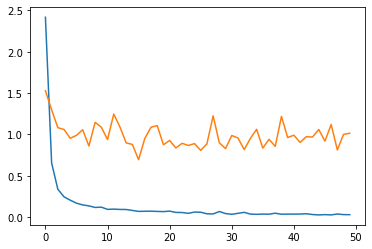

In [268]:
plt.plot(Mb_hist7.history['loss'])
plt.plot(Mb_hist7.history['val_loss'])

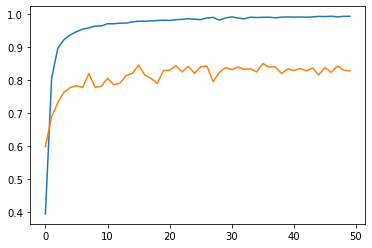

In [269]:
plt.plot(Mb_hist7.history['accuracy'])
plt.plot(Mb_hist7.history['val_accuracy'])

# DenseNet 직접 구현해보기

In [29]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ReLU
import tensorflow.keras as K

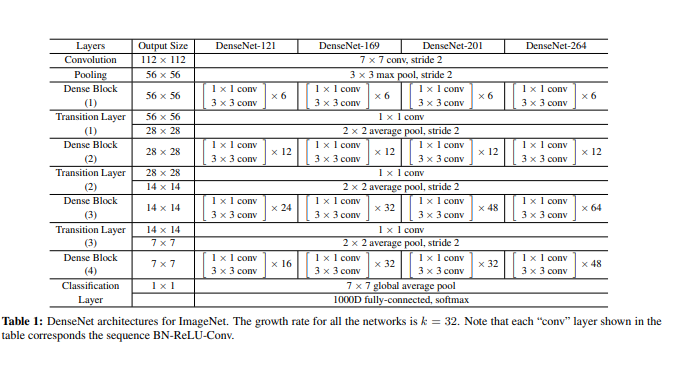

In [30]:
from IPython.display import Image
Image('./data/DenseNet구조.png')

In [31]:
# starts with 64 filters(k=32)
# In Dense block the 1*1 has 4 filters and we concatenate input with output tensor
# In transition reduce channels to half of the exisiting


def densenet(input_shape, n_classes, f=32):
    
    # BatchNormalization_ReLU_Convolution 순서 , k=kernel_size, s= strides
    def bn_rl_conv(x, f, k=1, s=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f,k, strides= s, padding='same')
        return x
    
    
    # bottleneck 구조 : 사용시 비슷한 parameter개수로 더 좋은 성능(add대신 concat)
    def dense_block(x,r): # r 반복횟수
        for _ in range(r):
            x = bn_rl_conv(y, 4*f)
            y = bn_rl_conv(y,f,3)
            x = concatenate([y,x])
    
    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1]//2)
        x  = AveragePooling2D(3, strides=2, padding='same')(x)
        return x
    
    
    
    input = Input(input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    #1 ~ 4 단계 반복 , 4단계는 transition layer 없음
    for r in [6,12,24,16]:
        d = dense_block(x,6)
        x = transition_layer_layer(d)
    
    x= GlobalMaxPooling2D()(x)
    output = Dense(n_classes,activation='softmax')(x)
    
    model = Model(input,output)
    return model
    

In [32]:
INPUT_SHAPE = 224,224,3
N_CLASSES = 1000

K
model = densenet(INPUT_SHAPE, N_CLASSES)
model.summary()

UnboundLocalError: local variable 'x' referenced before assignment

In [ ]:
finetune_model = Sequential()
finetune_model.add(Dense_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(1024, activation='relu'))
finetune_model.add(Dense(512, activation='relu'))
finetune_model.add(Dense(73, activation='softmax'))
finetune_model.summary()